In [49]:
#import required packages
import nltk
import pandas as pd
import csv
import re
import numpy as np
import os
import gensim
import spacy
import matplotlib.pyplot
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import ngrams
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis


In [83]:
from nltk.corpus import stopwords
#Default stopwords list
stopwords_def = stopwords.words('english')
print(stopwords_def)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [19]:
#Open sample cases
#draft_case_1 = open(r"./data/TEST1.txt", "r")
draft_case_2 = open(r"./data/sample_dataset_1/arizona immigration.txt", "r")
draft_case_3 = open(r"./data/sample_dataset_1/faa biodiversity.txt", "r")
draft_case_4 = open(r"./data/sample_dataset_1/save long island.txt", "r")
draft_case_5 = open(r"./data/sample_dataset_1/zinderman v la.txt", "r")

#draft_case_1 = draft_case_1.read()
draft_case_2 = draft_case_2.read()
draft_case_3 = draft_case_3.read()
draft_case_4 = draft_case_4.read()
draft_case_5 = draft_case_5.read()

documents = [draft_case_2, draft_case_3, draft_case_4, draft_case_5]

In [20]:
from nltk.corpus import words
from nltk.corpus import wordnet

#Define words as anything distinct in these two NLTK sets
real_word_set = set(words.words() + list(wordnet.words()))

#Want to keep certain words capitalized
proper_nouns = pd.read_csv('./preprocessing/proper_nouns.csv', header = None)
proper_nouns = proper_nouns.values.tolist()
proper_nouns = proper_nouns[0]

def recapitalize(word):
    if word in proper_nouns:
        return word
    if word.lower() in real_word_set:
        return word.lower()   
    else:
        return word
    
#Depluralize all nouns
import pattern
from pattern.en import singularize

#Find words that end with 's' that need to be handled differently than plurals
exceptions = pd.read_csv('./preprocessing/singularized_exceptions.csv')
exceptions_list = exceptions.to_dict('records')
exceptions_list = exceptions_list[0]

#Set a function to process these words differently
def singularize_esp(word):
    if word in exceptions_list:
        return exceptions_list.get(word)
    return singularize(word)
    

def replace_ngram(x):
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

def pos_lemmatize(word, tag):
    if tag.startswith('J'):
        return lemmatizer.lemmatize(word, pos='a')  # Adjective
    elif tag.startswith('V'):
        return lemmatizer.lemmatize(word, pos='v')  # Verb
    elif tag.startswith('N'):
        return lemmatizer.lemmatize(word, pos='n')  # Noun
    elif tag.startswith('R'):
        return lemmatizer.lemmatize(word, pos='r')  # Adverb
    else:
        return lemmatizer.lemmatize(word)  # Default to noun

#Get rid of proper nouns
name_remove = spacy.load("en_core_web_sm")
def remove_proper_nouns(text):
    doc = name_remove(text)
    filtered_text = " ".join([token.text for token in doc if token.pos_ != "PROPN"])
    return filtered_text

#Filter to keep only nouns
def nouns(word):
    pos_word = nltk.pos_tag(word)
    filtered = [word[0] for word in pos_word if word[1] in ['NN', 'NNP', 'NNS', 'NNPS']]
    return filtered    

In [80]:
lemmatized_documents = []

for doc in documents:

    draft_case = doc

    #Use regex to do a preliminary cleaning of the content
    ### Remove punctuation and numbers
    draft_case = re.sub("[0-9]", "", draft_case) #Removes numbers
    draft_case = re.sub(r"\/", " ", draft_case) #Replaces slashes with spaces
    draft_case = re.sub(r"\'", " ", draft_case) #Replaces apostrophes with spaces
    draft_case = re.sub(r"\-", " ", draft_case) #Replaces en-dash with spaces
    draft_case = re.sub(r"\–", " ", draft_case) #Replaces em-dash with spaces
    draft_case = re.sub(r"[.,?!()•$;:@§%&~\[\]\"]", "", draft_case) #Removes extraneous punctuation
    draft_case = re.sub(r"^$n','\n", "", draft_case, re.MULTILINE) #Removes empty lines
    draft_case = re.sub(r"\b\w{1,2}\b", '', draft_case) #Removes all one and two-character words (none have meaning)
    draft_case = re.sub(r"\n","", draft_case) #Removes extraneous line breaks


    #Remove extraneous information about lawyers and case detail that doesn't impact the content of the case
    starting_phrase = "PRELIMINARY STATEMENT" #Use this as the starter for when the actual lawsuit begins
    remove_before = r'^.*?{}'.format(re.escape(starting_phrase))
    draft_case = re.sub(remove_before, "", draft_case, flags=re.DOTALL)

    #Remove "FIRST AMENDED COMPLAINT", which is at the bottom of every page
    draft_case = re.sub(r"FIRST AMENDED COMPLAINT", "", draft_case)

    #These steps are done last since other words' removal will impact them
    draft_case = re.sub(r"\s+", " ", draft_case) #Removes multiple whitespaces
    draft_case = re.sub(r"([a-z])([A-Z])", r"\1 \2", draft_case) #Separates words that were joined together by double spaces

    #Word tokenization
    draft_case = word_tokenize(draft_case)
    print(draft_case[0:100])


    #Singularize
    draft_case = [singularize_esp(word) for word in draft_case]

    #Recapitalize proper nouns only
    draft_case = [recapitalize(word) for word in draft_case]

    #Remove stopwords
    #Remove all non-real words (done twice since wordnet "real words" set includes names)
    draft_case = [word for word in draft_case if ((word not in stopwords_def) and (word in real_word_set or word in proper_nouns))]
    draft_case = [remove_proper_nouns(word) for word in draft_case]

    #After removing non-real words, implement n-grams

    ##Return draft_case into a string
    draft_case = ' '.join(draft_case)
    ##Create n-grams using pointwise mutual information

    ###Create bigrams and use PMI to score them
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(str.split(draft_case))
    ####Apply a frequency filter
    finder.apply_freq_filter(25)
    bigram_scores = finder.score_ngrams(bigram_measures.pmi)

    ###Do the same for trigrams
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_words(str.split(draft_case))
    ####Frequency filter
    finder.apply_freq_filter(15)
    trigram_scores = finder.score_ngrams(trigram_measures.pmi)

    #Store the scores as dataframes
    bigram_pmi = pd.DataFrame(bigram_scores)
    bigram_pmi.columns = ['bigram', 'pmi']
    bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the bigrams with PMI greater than 5 (arbitrary threshold)
    bigram_pmi = bigram_pmi[bigram_pmi.apply(lambda bigram: bigram.pmi > 5, axis = 1)][:500]

    trigram_pmi = pd.DataFrame(trigram_scores)
    trigram_pmi.columns = ['trigram', 'pmi']
    trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)
    #Save only the trigrams with PMI greater than 5 (arbitrary threshold)
    trigram_pmi = trigram_pmi[trigram_pmi.apply(lambda trigram: trigram.pmi > 5, axis = 1)][:500]

    #Keep only the values
    bigrams = [' '.join(x) for x in bigram_pmi.bigram.values]
    trigrams = [' '.join(x) for x in trigram_pmi.trigram.values]

    # Concatenate n-grams
    draft_case = replace_ngram(draft_case)

    #Lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()

    #Re-tokenize
    draft_case = word_tokenize(draft_case)

    #Tag by part of speech
    from nltk import pos_tag
    tagged_word_content = pos_tag(draft_case)

    #Need to lemmatize using part of speech to ensure accuracy
    # Lemmatize using part of speech
    lemmatized_output = [pos_lemmatize(word, tag) for word, tag in tagged_word_content]
    lemmatized_output = nouns(lemmatized_output)
    
    print(lemmatized_output[0:100])

    lemmatized_documents.append(lemmatized_output)


['Case', 'DWL', 'Document', 'Filed', 'Page', 'MARK', 'BRNOVICHATTORNEY', 'GENERAL', 'Firm', 'State', 'Bar', 'Joseph', 'Kanefield', 'Arizona', 'Bar', 'Brunn', 'Beau', 'Roysden', 'III', 'Arizona', 'Bar', 'Drew', 'Ensign', 'Arizona', 'Bar', 'Central', 'Ave', 'Phoenix', 'Phone', 'Joseph', 'Kanefieldazaggov', 'Beau', 'Roysdenazaggov', 'Drew', 'Ensignazaggov', 'Attorneys', 'for', 'Plaintiff', 'State', 'Arizona', 'UNITED', 'STATES', 'DISTRICT', 'COURT', 'DISTRICT', 'ARIZONA', 'State', 'Arizona', 'DWL', 'Plaintiff', 'CORRECTED', 'COMPLAINT', 'Alejandro', 'Mayorkas', 'his', 'official', 'FOR', 'DECLARATORY', 'AND', 'capacity', 'Secretary', 'Homeland', 'INJUNCTIVE', 'RELIEF', 'Security', 'United', 'States', 'Department', 'Homeland', 'Security', 'Troy', 'Miller', 'his', 'official', 'capacity', 'serves', 'Senior', 'Official', 'Performing', 'the', 'Duties', 'the', 'Commissioner', 'Customs', 'and', 'Border', 'Protection', 'Tae', 'Johnson', 'his', 'official', 'capacity', 'Senior', 'Official', 'Perform

In [91]:
from nltk.probability import FreqDist

flattened_corpus = [word for doc in lemmatized_documents for word in doc]
# Create a frequency distribution
freq_dist = FreqDist(flattened_corpus)
# Get the most common words
most_common_words = freq_dist.most_common(80)

# Print the most common words and their frequencies
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")

#Add more stopwords
adtl_stopwords = pd.read_csv("./preprocessing/test_stopwords.csv", header = None)
adtl_stopwords = adtl_stopwords.values.tolist()
adtl_stopwords = adtl_stopwords[0]
print(stopwords_def)

lemmatized_documents = [[word for word in doc if word not in adtl_stopwords] for doc in lemmatized_documents]



noise: 151
level: 126
wildlife: 117
service: 109
member: 103
specie: 102
survey: 100
launch: 95
faa: 90
wind: 90
death: 88
beach: 87
space_x: 86
environment: 85
population: 81
city: 76
corp: 76
interest: 73
water: 69
rocket: 68
harm: 67
protection: 63
study: 63
increase: 59
cause: 55
construction: 54
conservation: 54
vehicle: 54
marine: 53
border: 51
change: 51
resource: 50
energy: 50
center: 49
source: 49
sea: 49
authorization: 48
mitigation: 47
violation: 46
group: 46
plantation: 46
letter: 46
land: 45
record: 45
range: 45
facility: 44
community: 43
CEQA: 43
migration: 42
fact: 42
wetland: 42
climate: 42
space: 42
refuge: 42
information: 41
request: 41
procedure: 41
regulation: 41
require: 41
part: 39
date_entry_number_page: 39
sound: 39
bird: 39
application: 39
prepare: 38
property: 38
biological_opinion: 38
period: 38
harassment: 38
vessel: 38
characterization: 38
department: 37
fire: 37
party: 37
event: 37
measure: 37
person: 36
park: 36
support: 36
explosion: 36
['i', 'me', 'my',

In [92]:
dictionary = corpora.Dictionary(lemmatized_documents)

doc_term_matrix = [dictionary.doc2bow(case) for case in lemmatized_documents]

In [93]:
coherence_list = []
for k in range(5,25):
    print('Topic number: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=40,\
                   iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=lemmatized_documents,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence_list.append((k,cm.get_coherence()))

Topic number: 5
Topic number: 6
Topic number: 7
Topic number: 8
Topic number: 9
Topic number: 10
Topic number: 11
Topic number: 12
Topic number: 13
Topic number: 14
Topic number: 15
Topic number: 16
Topic number: 17
Topic number: 18
Topic number: 19
Topic number: 20
Topic number: 21
Topic number: 22
Topic number: 23
Topic number: 24


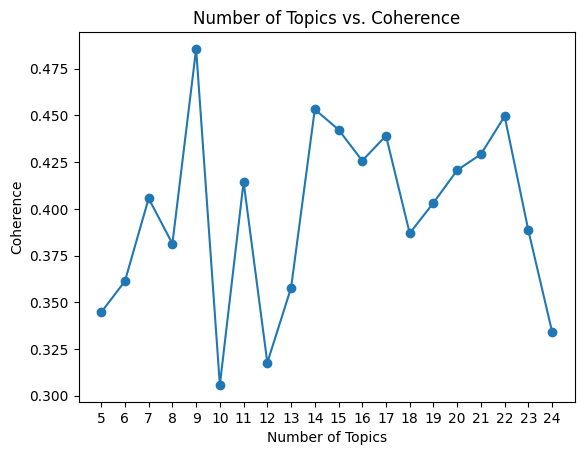

In [94]:
x_val = [x[0] for x in coherence_list]
y_val = [x[1] for x in coherence_list]
matplotlib.pyplot.plot(x_val,y_val)
matplotlib.pyplot.scatter(x_val,y_val)
matplotlib.pyplot.title('Number of Topics vs. Coherence')
matplotlib.pyplot.xlabel('Number of Topics')
matplotlib.pyplot.ylabel('Coherence')
matplotlib.pyplot.xticks(x_val)
matplotlib.pyplot.show()

In [95]:
""" from gensim.utils import simple_preprocess """

""" dict_singlefile = corpora.Dictionary(simple_preprocess(line, deacc =True) for line in lemmatized_output)
print("The dictionary has: " +str(len(dict_singlefile)) + " tokens")
doc_term_matrix = [dict_singlefile.doc2bow(text.lower().split()) for text in lemmatized_output] """ 

lda_model = gensim.models.LdaMulticore(corpus=doc_term_matrix,
                            id2word=dictionary,
                            num_topics=9,  # Adjust the number of topics as needed
                            random_state=100,
                            per_word_topics=True)

for idx, topic in lda_model.print_topics(num_topics = 9, num_words = 15):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"city" + 0.010*"service" + 0.009*"member" + 0.007*"specie" + 0.007*"corp" + 0.007*"wildlife" + 0.007*"faa" + 0.006*"beach" + 0.006*"launch" + 0.006*"interest" + 0.006*"noise" + 0.006*"water" + 0.006*"environment" + 0.006*"population" + 0.006*"space_x"
Topic: 1 
Words: 0.010*"level" + 0.010*"noise" + 0.008*"wind" + 0.007*"service" + 0.007*"death" + 0.007*"wildlife" + 0.007*"beach" + 0.006*"faa" + 0.006*"member" + 0.006*"environment" + 0.006*"interest" + 0.006*"population" + 0.006*"survey" + 0.005*"specie" + 0.005*"marine"
Topic: 2 
Words: 0.010*"wildlife" + 0.010*"noise" + 0.009*"level" + 0.008*"service" + 0.008*"environment" + 0.007*"launch" + 0.007*"specie" + 0.007*"wind" + 0.007*"member" + 0.006*"death" + 0.006*"faa" + 0.006*"survey" + 0.006*"beach" + 0.006*"space_x" + 0.006*"population"
Topic: 3 
Words: 0.011*"noise" + 0.009*"level" + 0.008*"faa" + 0.008*"member" + 0.007*"specie" + 0.007*"wildlife" + 0.007*"survey" + 0.006*"environment" + 0.006*"space_x" + 0.0

In [96]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
pd.set_option("display.max_rows", 600)
from pathlib import Path  
import glob